In [2]:
#save degree of rotation into CSV
    # construct dataframe : columnA filename, columnB: section#, columnC: centroid of section, columnD: degree of rotation

#read degree of rotation
#read H&E image
#mask each section
    #read_DL_mask
    #label_DL_mask
    #label == numsec
#rotate H&E image
#crop H&E image

In [ ]:
# imcrop_masked = np.multiply(np.array(imcrop),objmask[..., None].astype(np.bool))

In [87]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage import util
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [70]:
# Define minimum sizes of tissue objects at 1um resolution
minTA = 20000
minTAhole = 100
minDermhole = 5000
minepisize=1000
whitespace=12 #define background pixel value

In [75]:
src = r"\\fatherserverdw\kyuex\clue images\1um"
dst = os.path.join(src, 'imaligncrop')

In [78]:
degrot_LUT = pd.read_csv(r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\tmp\CLUEdegrot.csv")

In [83]:
#TODO: iterate through image instead of dataframes,so it's faster
for idx, LUT in degrot_LUT.iterrows():
    imname = LUT['imname']
    centroid = LUT['secCent']
    degrot =  LUT['degrot']
    sec = LUT['secN']

    im_path =  r"\\fatherserverdw\kyuex\clue images\1um\{}.tif".format(imname)
    mask_path = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\{}.tif".format(imname)
    im = Image.open(im_path)
    mask = Image.open(mask_path)
    TAbig = np.array(mask)

    #label mask
    (width, height) = (mask.width // 10, mask.height // 10) #downsize by 10
    mask_resized = mask.resize((width, height), resample=0) #nearest interpolation to rescale
    TA = np.array(mask_resized) # convert DL mask to numpy array
    # separate touching tissue sections using WATERSHED segmentation
    sure_foreground = (2 < TA) & (TA < whitespace - 1) #define tissue section conservatively by removing corneum==1, and removing fat==12, so this foreground does not touch adjacent tissue section for sure.

    sure_fg = closing(sure_foreground, square(3))  # 13sec
    # remove small objects not connected to the tissue section
    sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec

    sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole).astype(np.uint8)

    bw = closing(TA < whitespace, square(3))  # 12 is background
    bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
    bw = remove_small_holes(bw, area_threshold=minTAhole)
    # morphological opening : erosion followed by an dilation to remove small objects
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
    # dilate to be more lenient in defining tissue section area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)

    sure_fg_label = label(sure_fg).astype(np.int32)
    sure_fg_label = sure_fg_label + 1 #objects are 2~N
    sure_fg_label[unknown] = 0 #middle ground is 0

    #get labeled image
    TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR) #convert downsized DL mask to BGR color channel
    label_image = cv2.watershed(TAbgr, sure_fg_label) #apply watershed using fg,bg,mg, defined mask

    # iterate each section
    epi = (TA == 1) | (TA == 2)
    derm = (2 < TA) & (TA < whitespace)
    derm = remove_small_holes(derm, area_threshold=minDermhole)

    epi2 = epi & ~derm
    epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)

    numsecmax = np.max(label_image)

    #
    numsec = sec
    print('section N: ', numsec, '/', numsecmax-1)
    msktmp = label_image == numsec+1
    stats = regionprops(msktmp.astype(np.uint8))
    centroid = stats[0].centroid #NOTE:this returns (y,x)!!
    cent = (10*centroid[1],10*centroid[0])

    TAtmp = deepcopy(TAbig)
    mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
    # delete non-ROI from scaled up ROI
    kernel = np.ones((20, 20), np.uint8)
    mskbig = cv2.dilate(mskbig, kernel, iterations=3)
    TAtmp[mskbig == 0] = 0  #1sec

    imcrop = np.multiply(np.array(im),TAtmp[..., None].astype('bool'))

    imrot = rotate(imcrop, degrot, resize=True, preserve_range=True, order=0)

    [xt, yt] = np.where(imrot[:,:,0]) #tissue mask to point clouds,don't know why there are three arrays
    imrot2 = imrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]

    imrot2[imrot2==0] = 235

    Image.fromarray(imrot2).save(
        os.path.join(dst, '{}_sec{:02d}.png'.format(imname, sec)))


C:\Users\kyuha\AppData\Local\Temp\ipykernel_16844\3745978273.py:36: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


section N:  1 / 1


C:\Users\kyuha\AppData\Local\Temp\ipykernel_16844\3745978273.py:71: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imcrop = np.multiply(np.array(im),TAtmp[..., None].astype(np.bool))


MemoryError: Unable to allocate 34.4 GiB for an array with shape (3, 24809, 20688, 3) and data type float64

In [92]:
def rotate2(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [93]:
rotated=rotate2(imcrop,degrot)

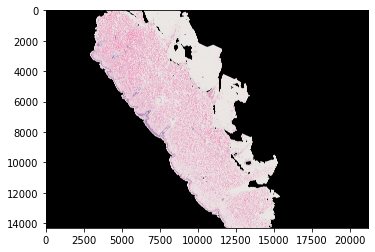

In [94]:
plt.imshow(rotated)

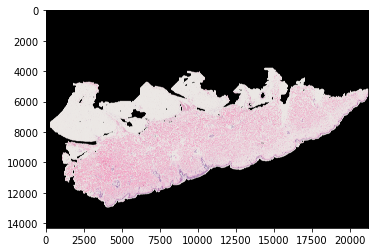

In [95]:
plt.imshow(imcrop)

In [46]:
imrot2[imrot2==0] = 235

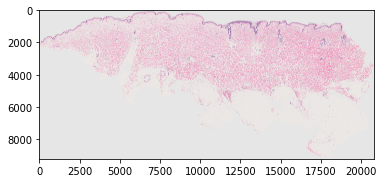

In [45]:
plt.imshow(imrot2)